# DLO-JZ Data parallism ZeRO et Pipeline parallelism - Jour 4

![Monstertruck](./images/MonsterTruck.png)


## Objet du notebook

Le but de ce *notebook* est d'optimiser un code d'apprentissage d'un modèle *Phi-2* sur *Imagenet* pour Jean Zay en implémentant :
* **TP 1** : Passage à CoAtNet
* **TP 2** : Pipeline parallelism avec PyTorch
* **TP 3** : Deepspeed - ZeRo Data Parallelism
* **TP 4** : Deepspeed - Pipeline Parallelism et comparatif


Les cellules dans ce *notebook* ne sont pas prévues pour être modifiées, sauf rares exceptions indiquées dans les commentaires. Les TP se feront en modifiant le code `dlojz.py`.

Les directives de modification seront marquées par l'étiquette **TODO :** dans le *notebook* suivant.
 
Les solutions sont présentes dans le répertoire `solutions/`.

*Notebook rédigé par l'équipe assistance IA de l'IDRIS, juin 2023*


------------------------

### Environnement de calcul

Un module PyTorch doit avoir été chargé pour le bon fonctionnement de ce Notebook. **Nécessairement**, le module `pytorch-gpu/py3/1.11.0` :

In [50]:
!module list

Currently Loaded Modulefiles:
 1) cuda/11.2                5) openmpi/4.1.1-cuda   9) sparsehash/2.0.3        
 2) nccl/2.9.6-1-cuda        6) intel-mkl/2020.4    10) libjpeg-turbo/2.1.3     
 3) cudnn/8.1.1.33-cuda      7) magma/2.5.4-cuda    11) pytorch-gpu/py3/1.11.0  
 4) gcc/8.5.0(8.3.1:8.4.1)   8) sox/14.4.2          
>

Les fonctions *python* de gestion de queue SLURM dévelopées par l'IDRIS et les fonctions dédiées à la formation DLO-JZ sont à importer.

Le module d'environnement pour les *jobs* et la taille des images sont fixés pour ce *notebook*.

**TODO :** choisir un *pseudonyme* (maximum 5 caractères) pour vous différencier dans la queue SLURM et dans les outils collaboratifs pendant la formation.

In [60]:
from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from dlojz_tools import controle_technique, compare, GPU_underthehood, plot_accuracy, lrfind_plot, pipe_memory, turbo_profiler, comm_profiler
MODULE = 'pytorch-gpu/py3/1.11.0'
image_size = 224
account = 'sos@a100'
name = 'Nathan'   ## TODO Pseudonyme à choisir

------------------------------------

### Gestion de la queue SLURM

Cette partie permet d'afficher et de gérer la queue SLURM.

Pour afficher toute la queue *utilisateur* :

In [3]:
display_slurm_queue()


 Done!


**Remarque**: Cette fonction utilisée plusieurs fois dans ce *notebook* permet d'afficher la queue de manière dynamique, rafraichie toutes les 5 secondes. Cependant elle ne s'arrête que lorsque la queue est vide. Si vous désirez reprendre la main sur le *notebook*, il vous suffira d'arrêter manuellement la cellule avec le bouton *stop*. Cela a bien sûr aucun impact sur le *scheduler* SLURM. Les *jobs* ne seront pas arrêtés.

Si vous voulez arrêter des *jobs* dans la queue :
* Annuler tous vos *jobs* dans la queue (décommenter la ligne suivante)
* Annuler un *job* dans votre queue (décommenter la ligne suivante et ajouter le numéro du *job* à la fin de la ligne)


In [44]:
#!scancel -u $USER

------------------------------------

### Debug

Cette partie *debug* permet d'afficher les fichiers de sortie et les fichiers d'erreur du *job*.

Il est nécessaire dans la cellule suivante (en décommentant) d'indiquer le *jobid* correspondant sous le format suivant.

***Remarque*** : dans ce notebook, lorsque vous soumettrez un job, vous recevrez en retour le numéro du job dans le format suivant : `jobid = ['123456']`. La cellule ci-dessous peut ainsi être facilement actualisée.

In [45]:
jobid = ['2088207']

Fichier de sortie :

In [46]:
%cat {search_log(contains=jobid[0])[0]}

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cat {search_log(contains=jobid[0])[0]}'


Fichier d'erreur :

In [47]:
%cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}'


--------------

### Différence de scripts <a id='diff_scripts'></a>

Pour le *debug* ou pour comparer son code avec les solutions mises à disposition, la fonction suivante permet d'afficher une page html contenant un différentiel de fichiers texte.

In [48]:
s1 = "dlojz.py"
s2 = "./solutions/dlojz4_2.py"
compare(s1, s2)

Voir le résultat du différentiel de fichiers sur la page suivante (attention au spoil !) :

[compare.html](compare.html)

--------------

# TP4_0 : Préparation

**TODO** : copier-coller la solution `solutions/dlojz4_0.py` dans `dlojz.py` afin d'ajouter dans le code les 2 éléments suivants nécessaires pour la suite des TP :
* utiliser une taille d'image équivalente pour la *validation* et le *training* car *CoatNet* n'a pas la même souplesse que *ResNet*, il nécessite une même taille d'image (multiple de 32).
* afficher dans les *logs* l'empreinte mémoire de **tous** les GPU.

**À noter** : Pendant tout le TP, nous utiliserons une taille d'image de 352 x 352, qui correspond à la taille classique utilisée pour ce modèle.

Pour visualiser ces changements, veuillez utiliser le différentiel de fichiers suivant.

In [49]:
s1 = "dlojz.py"
s2 = "./solutions/dlojz4_0.py"
compare(s1, s2)

[compare.html](compare.html)

In [4]:
# copier/coller la solution si nécessaire
!cp solutions/dlojz4_0.py dlojz.py

--------------


# TP4_1 : CoAtNet

Ce TP consiste à lister les versions du modèle *CoATNet*, de l'appliquer à notre code et de juger des problématques liées aux gros modèles.

### Liste des versions de CoAtNet

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [2]:
n_gpu = 1
batch_size = 32
command = f'CoAtNet/coatnet.py'
jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 964326
jobid = ['964326']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'éviter de relancer un job par erreur.

In [6]:
#jobid = ['1790096']

In [7]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            958611    gpu_p5   Nathan  ssos025  R       1:02      1 jean-zay-iam14

 Done!


In [8]:
%cat {search_log(name, contains=jobid[0])[0]}

CoAtNet 0: output shape = torch.Size([1, 1000]), N of Parameters = 20918064
CoAtNet 1: output shape = torch.Size([1, 1000]), N of Parameters = 39890496
CoAtNet 2: output shape = torch.Size([1, 1000]), N of Parameters = 64652672
CoAtNet 3: output shape = torch.Size([1, 1000]), N of Parameters = 131079872
CoAtNet 4: output shape = torch.Size([1, 1000]), N of Parameters = 228407456
CoAtNet 5: output shape = torch.Size([1, 1000]), N of Parameters = 610269344
CoAtNet 6: output shape = torch.Size([1, 1000]), N of Parameters = 1453918848
CoAtNet 7: output shape = torch.Size([1, 1000]), N of Parameters = 2362119808
Thu Mar  7 13:09:13 CET 2024


## CoAtNet-7

**TODO** : dans le script `dlojz.py` :

* Importer la description des architectures *CoAtNet*.

```python
from CoAtNet.coatnet import coatnet_7
```
* Remplacer :

  `model = models.resnet50()` par `model = coatnet_7((args.image_size,args.image_size))`

  et 

  `archi_model = 'Resnet-50'` par `archi_model = 'CoAtNet-7'`


Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.


In [65]:
n_gpu = 1
batch_size = 8
command = f'dlojz.py -b {batch_size} --test --image-size {image_size}'
jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 965537
jobid = ['965537']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculler la cellule précédente en mode `Raw NBConvert`, afin d'éviter de relancer un job par erreur.

In [62]:
# jobid = ['902284']

In [69]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            965544    gpu_p5   Nathan  ssos025 CG       2:33      1 jean-zay-iam14
            965537    gpu_p5   Nathan  ssos025 CG       3:16      1 jean-zay-iam14
            965550    gpu_p5   Nathan  ssos025  R       2:39      1 jean-zay-iam14

 Done!


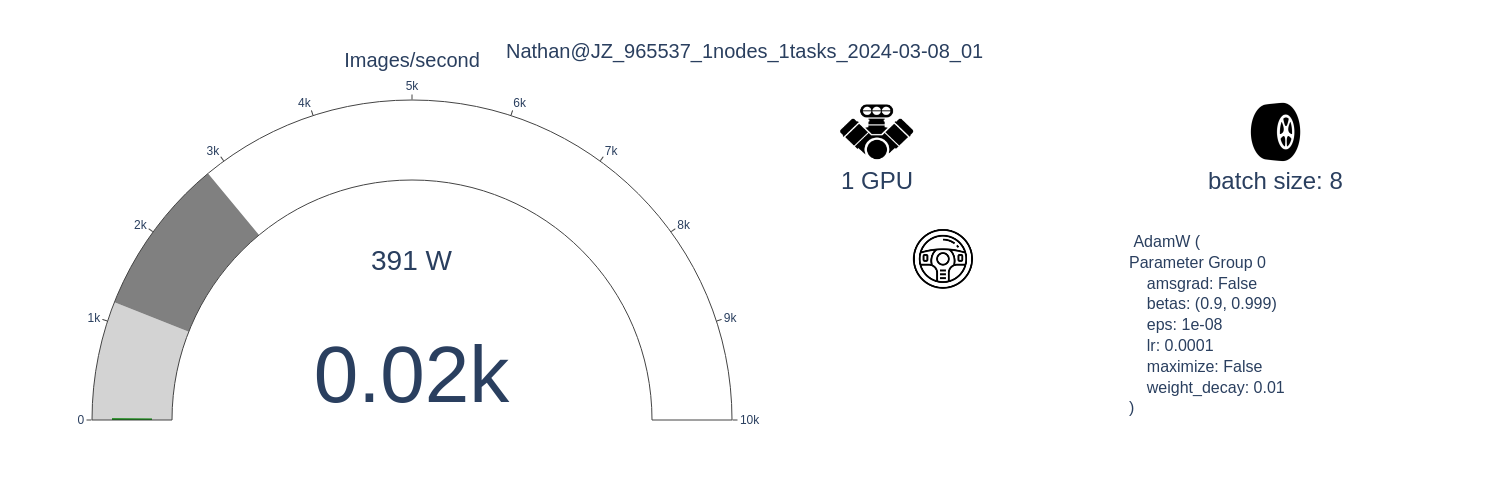

Train throughput: 18.11 images/second
GPU throughput: 18.12 images/second
epoch time: 70736.15 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.441510 sec (21.3%/78.3%) +/- 0.009525
loading step time average (IO + CPU to GPU transfer): 0.000188 sec +/- 0.000056


In [70]:
controle_technique(jobid)

### Test d'occupation mémoire

Afin de mesurer l'impact de la taille de batch sur l'occupation mémoire et sur le *throughput*, la cellule suivante permet de soumettre plusieurs *jobs* avec des tailles de *batch* croissantes. Dans les cas où la mémoire est saturée et dépasse la capacité du GPU, le système renverra une erreur *CUDA Out of Memory*.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [66]:
n_gpu = 1
batch_size = [4, 8, 16, 32]
command = [f'dlojz.py -b {b} --test'
          for b in batch_size]
jobids = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobids = {jobids}')

batch job 0: 1 GPUs distributed on 1 nodes with 1 tasks / 1 gpus per node and 8 cpus per task
Submitted batch job 965542
Submitted batch job 965544
Submitted batch job 965547
Submitted batch job 965550
jobids = ['965542', '965544', '965547', '965550']


Copier-coller la sortie `jobids = ['xxxxx', ...]` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [19]:
# jobids = ['890753', '890755', '890757', '890760']

In [19]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            964416    gpu_p5   Nathan  ssos025  R       2:45      1 jean-zay-iam20
            964417    gpu_p5   Nathan  ssos025  R       2:45      1 jean-zay-iam20
            964418    gpu_p5   Nathan  ssos025  R       2:45      1 jean-zay-iam28

 Done!


/gpfsdswork/projects/idris/sos/ssos025/formations/dlo-jz/Jour4/tp_gros_models/dlojz_tools.py:275: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



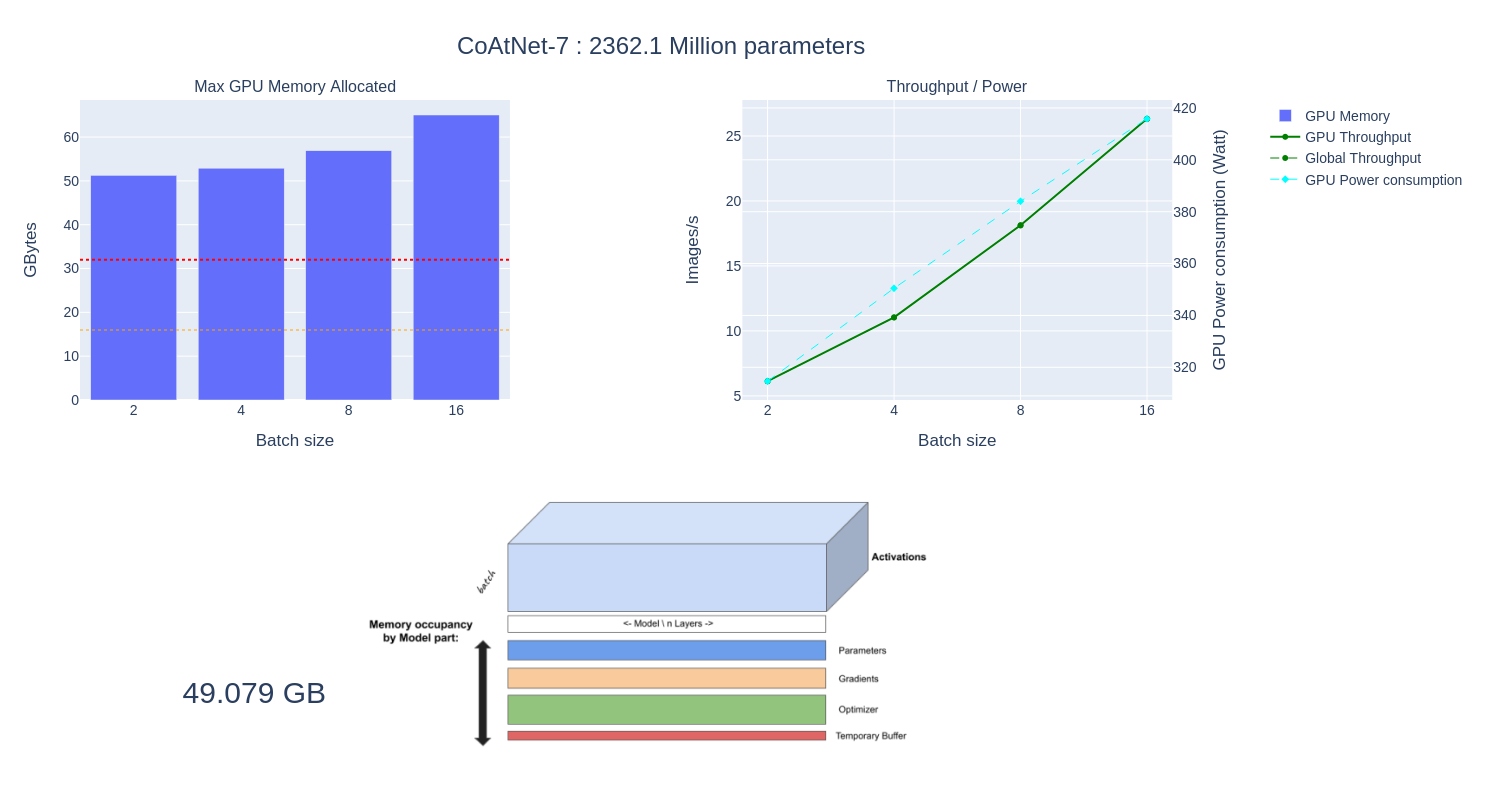

Batch size per GPU: 2 Max GPU Memory Allocated: 51.25 GB, Troughput: 6.128 images/second
Batch size per GPU: 4 Max GPU Memory Allocated: 52.89 GB, Troughput: 11.040 images/second
Batch size per GPU: 8 Max GPU Memory Allocated: 56.88 GB, Troughput: 18.127 images/second
Batch size per GPU: 16 Max GPU Memory Allocated: 65.03 GB, Troughput: 26.326 images/second
Memory occupancy by Model part : 49.079 +/- 0.383 GB


In [71]:
GPU_underthehood(jobids)

![Commentaires](images/cedez.png "Assurez-vous que tout se passe bien avant de continuer!")

------------------------

# TP4_2 : Pipelined Parallelism de PyTorch

Ce TP consiste à implémenter le *Pipelined Parallelism* de PyTorch et de comparer cette solution avec les autres solutions.

La principale contrainte induite est de structurer le modèle comme suit, avec des `torch.nn.Sequential` pour chaque section et pour le modèle entier :

![pipeline pytorch](images/pipeline2pytorch.png)

Le *Pipeline Parallelism* de PyTorch est de type standard **GPipe**.

![G Pipe](images/gpipe.png)


**À noter** : Le code modifié permettra de faire de l'*Hybrid Parallelism* (DP + PP). 

Chaque instance créée par *Data Parallelism* sera associée à une *task* Slurm, et chacune de ces instances pourra elle-même sollliciter plusieurs GPU pour tourner en mode *Pipelined Parallelism*.

Dans notre cas, nous testerons le code seulement en mode *Pipelined Parallelism*, sur 1 *task* associée à 4 GPU.

**TODO** : dans le script `dlojz.py`:

* Importer les fonctions nécessaires.

```python
from torch.distributed.pipeline.sync import Pipe
import tempfile
from torch.distributed import rpc
```
* Ajouter l'argument `--chunks` (pour le nombre de *micro batches*) avant le *parser* les arguments.

```python
parser.add_argument('--chunks', default=1, type=int, help='number of chunks for Pipelined Parallelism')
      
args = parser.parse_args()

```

* Initialiser le *Framework RPC*, juste après la configuration de la distribution.

```python
# Initialize RPC Framework, Pipe depends on it
tmpfile = tempfile.NamedTemporaryFile()
rpc.init_rpc(
    name=f'worker{idr_torch.rank}',
    rank=0,
    world_size=1,
    rpc_backend_options=rpc.TensorPipeRpcBackendOptions(
        init_method="file://{}".format(tmpfile.name),
	    # Specifying _transports and _channels is a workaround and we no longer
        # will have to specify _transports and _channels for PyTorch 
        # versions >= 1.8.1 (Not True for Jean Zay)
	    # With Jean Zay, _transports must be equal to ["shm", "uv"] and not ["ibv", "uv"]
        _transports=["shm", "uv"],
        _channels=["cuda_ipc", "cuda_basic"],
    )
)
```

* Structurer le modèle pour le *Pipelined Parallelism*.

```python
# define model
model = coatnet_7((args.image_size,args.image_size))

# How many sections
nb_part = torch.cuda.device_count()//int(os.environ['SLURM_NTASKS_PER_NODE']) 
# device number where the first part of the model will run
first_part = idr_torch.local_rank*nb_part
# list of devices involved for pipelined Parallelism
gpus = [g for g in range(first_part, first_part+nb_part)]

class LambdaModule(torch.nn.Module):
    def __init__(self, lambd):
        super().__init__()
        assert isinstance(lambd, type(lambda x: x))
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

lambda_fc = LambdaModule(lambda x: x.view(-1, 3072))

section0 = torch.nn.Sequential(*model.s0, *model.s1, *model.s2, *model.pres3).to(gpus[0])
section1 = torch.nn.Sequential(*model.s3[:15]).to(gpus[1])
section2 = torch.nn.Sequential(*model.s3[15:30]).to(gpus[2])
section3 = torch.nn.Sequential(*model.s3[30:], *model.s4, model.pool, lambda_fc, model.fc).to(gpus[3])
pipe_model = torch.nn.Sequential(*section0, *section1, *section2, *section3)

# Pipe the model, chunks=n means that the batch (size according to batch size) will be shared to n micro batches (size = batch_size/chunks)
model = Pipe(pipe_model, chunks=args.chunks, checkpoint="never")

archi_model = 'CoAtNet-7'
```

* Modifier la déclaration du `DistributedDataParallel` pour prendre en compte le fait qu'il y a plusieurs GPU associés à une seule *task* pour le *Pipelined Parallelism*, en indiquant simplement :

```python
model = DistributedDataParallel(model)
```
* Envoyer les métriques de *validation* au dernier *device* du *Pipe*.

```python
## Initialisation  
if idr_torch.rank == 0: accuracies = []
val_loss = torch.Tensor([0.]).to(gpus[-1])                  # send to GPU
val_accuracy = torch.Tensor([0.]).to(gpus[-1])              # send to GPU
```
* Dans les boucles de *training* et de *validation*, envoyer les *Input*/images au premier GPU et les *labels* au dernier GPU.

```python
# distribution of images and labels to all GPUs
images = images.to(gpus[0], non_blocking=args.non_blocking)
labels = labels.to(gpus[-1], non_blocking=args.non_blocking)
```
   et 

```python
# distribution of images and labels to all GPUs
val_images = val_images.to(gpus[0], non_blocking=args.non_blocking)
val_labels = val_labels.to(gpus[-1], non_blocking=args.non_blocking)
```

* La sortie du modèle *Pipelined* est au format `Rref`, il faudra utiliser la méthode `.local_value()` pour le transformer en tenseur pour le calcul de la *loss*, dans les boucles de *training* et de *validation*.

```python
# Runs the forward pass with autocasting.
with autocast():
    outputs = model(images).local_value()
    loss = criterion(outputs, labels)
```
et

```python
# Runs the forward pass with no grade mode.
with torch.no_grad():
    with autocast():
        val_outputs = model(val_images).local_value()
        loss = criterion(val_outputs, val_labels)
```

* Ajouter pour les logs, la mesure de l'empreinte mémoire sur tous les GPU avec la ligne suivante après la boucle d'apprentissage.

```python
    else:                                                                                                      #
        print(f'MaxMemory for GPU:{idr_torch.rank} {torch.cuda.max_memory_allocated()} Bytes')                 #
#***************************************************************************************************************
    for g in gpus: print(f'MaxMemory for GPU:{g} {torch.cuda.max_memory_allocated(device=g)} Bytes')
```

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [72]:
n_gpu = 4
batch_size = 32
command = f'dlojz.py -b {batch_size} --chunks 4 --test'
jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=name, n_gpu_per_task=4, 
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 4 GPUs distributed on 1 nodes with 1 tasks / 4 gpus per node and 32 cpus per task
Submitted batch job 965707
jobid = ['965707']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculler la cellule précédente en mode `Raw NBConvert`, afin d'éviter de relancer un job par erreur.

In [23]:
#jobid = ['1790229']

In [74]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            965720    gpu_p5   Nathan  ssos025  R       3:05      1 jean-zay-iam14

 Done!


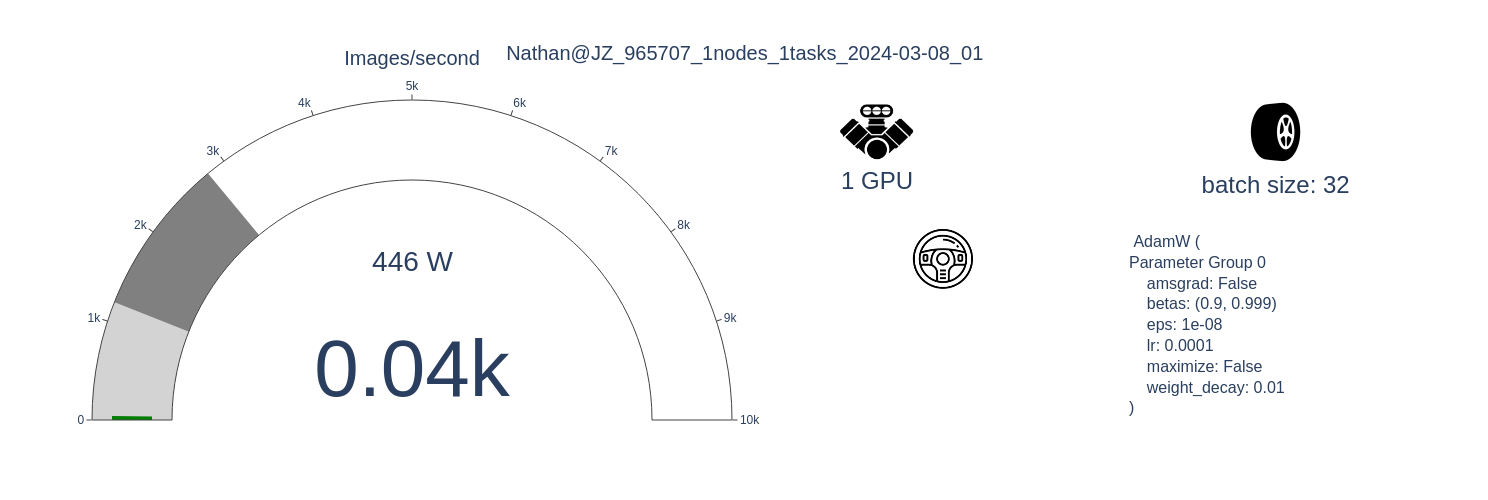

Train throughput: 41.71 images/second
GPU throughput: 41.72 images/second
epoch time: 30717.90 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.767004 sec (28.6%/69.7%) +/- 0.038838
loading step time average (IO + CPU to GPU transfer): 0.000234 sec +/- 0.000026


In [75]:
controle_technique(jobid)

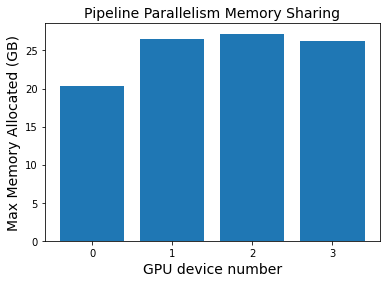

In [76]:
pipe_memory(jobid)

### Test d'occupation mémoire

Afin de mesurer l'impact de la taille de batch sur l'occupation mémoire et sur le *throughput*, la cellule suivante permet de soumettre plusieurs *jobs* avec des tailles de *batch* croissantes. Dans les cas où la mémoire est saturée et dépasse la capacité du GPU, le système renverra une erreur *CUDA Out of Memory*.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [73]:
n_gpu = 4
chunks = [(16,2), (32,4), (48,6), (128,8)]
command = [f'dlojz.py -b {c[0]} --chunks {c[1]} --test'
          for c in chunks]
jobids = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,  n_gpu_per_task=4, 
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobids = {jobids}')

batch job 0: 4 GPUs distributed on 1 nodes with 1 tasks / 4 gpus per node and 32 cpus per task
Submitted batch job 965711
Submitted batch job 965715
Submitted batch job 965718
Submitted batch job 965720
jobids = ['965711', '965715', '965718', '965720']


Copier-coller la sortie `jobids = ['xxxxx', ...]` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [28]:
# jobids = ['948515', '948516', '948517', '948519']

In [26]:
display_slurm_queue(name)


 Done!


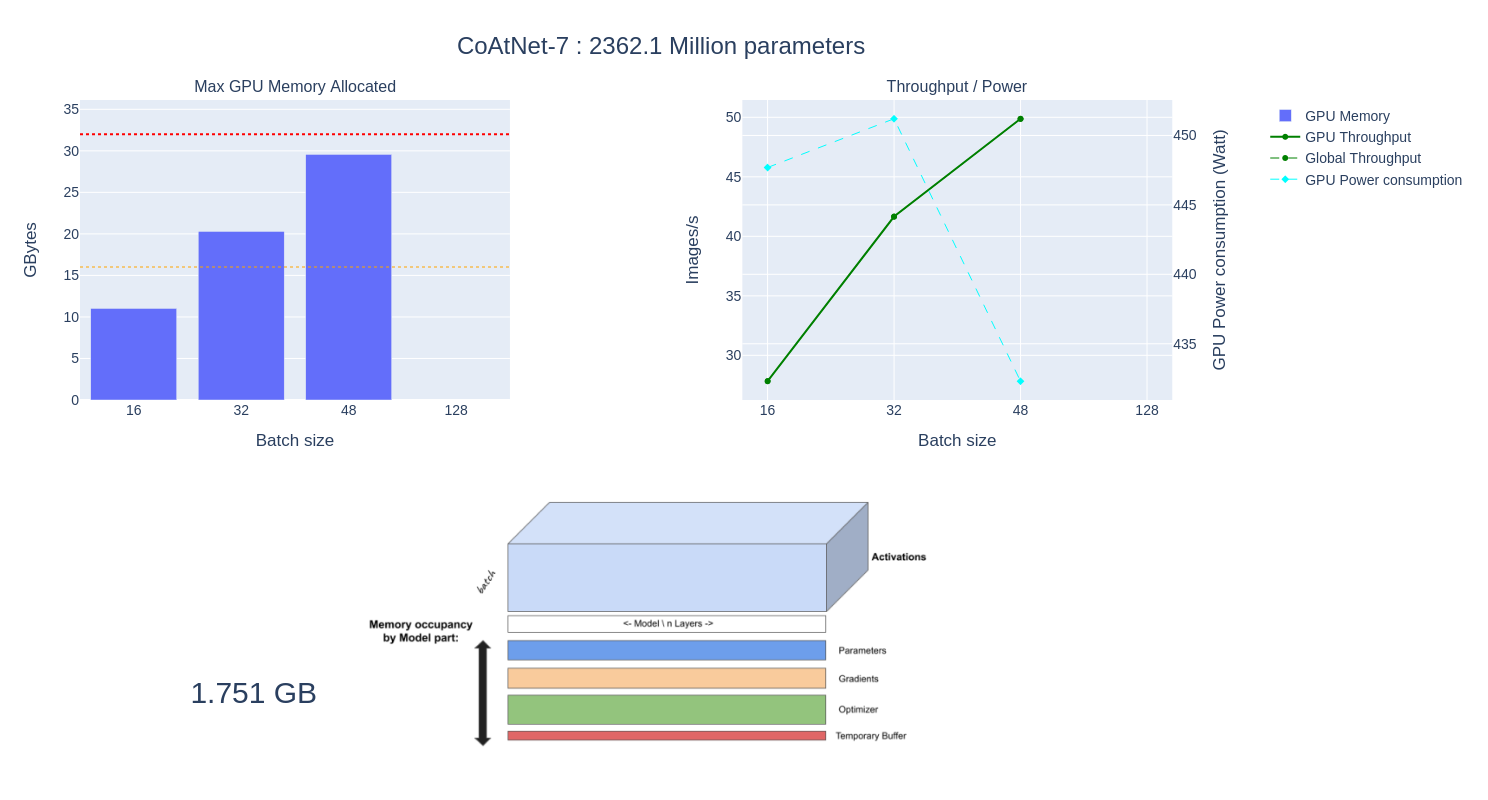

Batch size per GPU: 16 Max GPU Memory Allocated: 11.02 GB, Troughput: 27.833 images/second
Batch size per GPU: 32 Max GPU Memory Allocated: 20.29 GB, Troughput: 41.662 images/second
Batch size per GPU: 48 Max GPU Memory Allocated: 29.57 GB, Troughput: 49.880 images/second
Batch size per GPU: 128 CUDA out of memory
Memory occupancy by Model part : 1.751 +/- 0.000 GB


In [78]:
GPU_underthehood(jobids, calcul_memo=True)

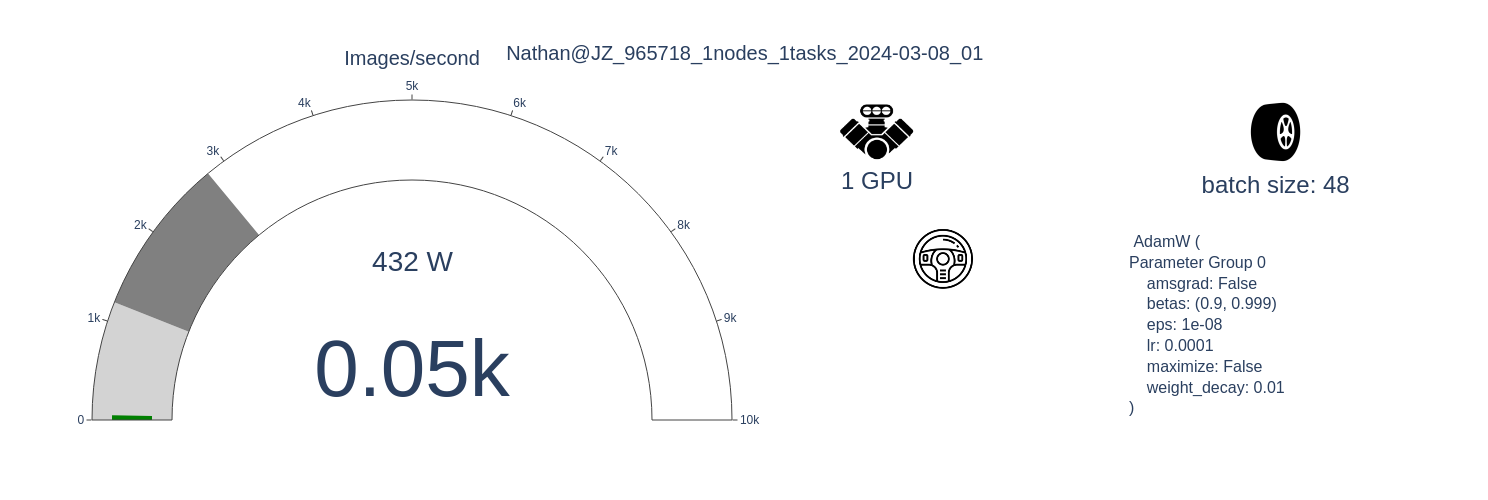

Train throughput: 49.87 images/second
GPU throughput: 49.88 images/second
epoch time: 25691.70 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.962308 sec (29.6%/69.1%) +/- 0.045140
loading step time average (IO + CPU to GPU transfer): 0.000253 sec +/- 0.000032


In [79]:
controle_technique([jobids[-2]])

![Commentaires](images/cedez.png "Assurez-vous que tout se passe bien avant de continuer!")

------------------------

# TP4_3 : Deepspeed

### Préparation

Il faut enlever le *Pipelined Parallelism* du fichier `dlojz.py`. Nous vous proposons de copier-coller la solution du TP4_1 pour revenir à l'état précédent.

**TODO** :

* Copier-coller la solution `solutions/dlojz4_1.py` dans le fichier `dlojz.py`

In [33]:
# copier/coller la solution si nécessaire
!cp solutions/dlojz4_1.py dlojz.py

### Implémentation de deepspeed

Ce TP consiste à implémenter *Deepspeed* pour intégrer l'optimisation **ZeRO** pour le *Data Parallelism*.


**TODO** : dans le script `dlojz.py` :

* Importer *Deepspeed*.

```python
import deepspeed
```
* Intégrer la configuration de *Deepspeed* par fichier de configuration *json* dans le *parser* d'arguments.

```python
# Include DeepSpeed configuration arguments
parser = deepspeed.add_config_arguments(parser)
```
* Remplacer le mécanisme de distribution de PyTorch par celui de *Deepspeed* :

À la place de :
```python
# configure distribution method: define rank and initialise communication backend (NCCL)
dist.init_process_group(backend='nccl', init_method='env://',
                        world_size=idr_torch.size, rank=idr_torch.rank)
...
model = model.to(gpu)
...
model = DistributedDataParallel(model, device_ids=[idr_torch.local_rank])
...

```
mettre :
```python
# Deepspeed initialization - force port number if several job run on the same node 
deepspeed.init_distributed(distributed_port=os.environ['MASTER_PORT'])
model_engine, optimizer, _, _ = deepspeed.initialize(args=args,
                                                     model=model, 
                                                     model_parameters=model.parameters(),
                                                     )
```

**À noter** : Nous garderons, comme indiqué dans la documentation de *Deepspeed*, la distinction entre le modèle PyTorch `model` et le modèle encapsulé avec *Deepspeed* `model_engine`.

* Appliquer le nouveau modèle dans l'étape de *forward*.

```python
outputs = model_engine(images)

```
et

```python
val_outputs = model_engine(val_images)
```


* Déléguer les étapes de *backward* et d'actualisation des poids à *Deepspeed* dans la boucle de *training* en remplaçant :

```python
# backward and optimize
loss.backward()
optimizer.step()
```

par

```python
#runs backpropagation
model_engine.backward(loss)

#weight update
model_engine.step()

```


### Configuration de ZeRO

La configuration de *Deepspeed* se fait par fichier *JSON* :

In [80]:
 %%writefile ds_config.json
{ "train_micro_batch_size_per_gpu": 16,
  "gradient_accumulation_steps": 1,
  
  "fp16": {
    "enabled": true
 },
  "optimizer": {
    "type": "AdamW",
    "params": {
      "lr": 0.001,
      "weight_decay": 5e-4
    }
  },
 "scheduler": {
      "type": "OneCycle",
      "params": {
          "cycle_min_lr": 1e-6,
          "cycle_max_lr": 1e-3,
          "decay_lr_rate": 1e-6
      }
  },
 
 "zero_optimization": {
    "stage": 2
 },
 "zero_allow_untested_optimizer": true
}

Overwriting ds_config.json


Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [81]:
n_gpu = 4
batch_size = 16
command = f'dlojz.py -b {batch_size} --test --deepspeed --deepspeed_config ds_config.json'
jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 4 GPUs distributed on 1 nodes with 4 tasks / 4 gpus per node and 8 cpus per task
Submitted batch job 965842
jobid = ['965842']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [36]:
#jobid = ['1790826']

In [84]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            965847    gpu_p5   Nathan  ssos025  R       4:15      1 jean-zay-iam14

 Done!


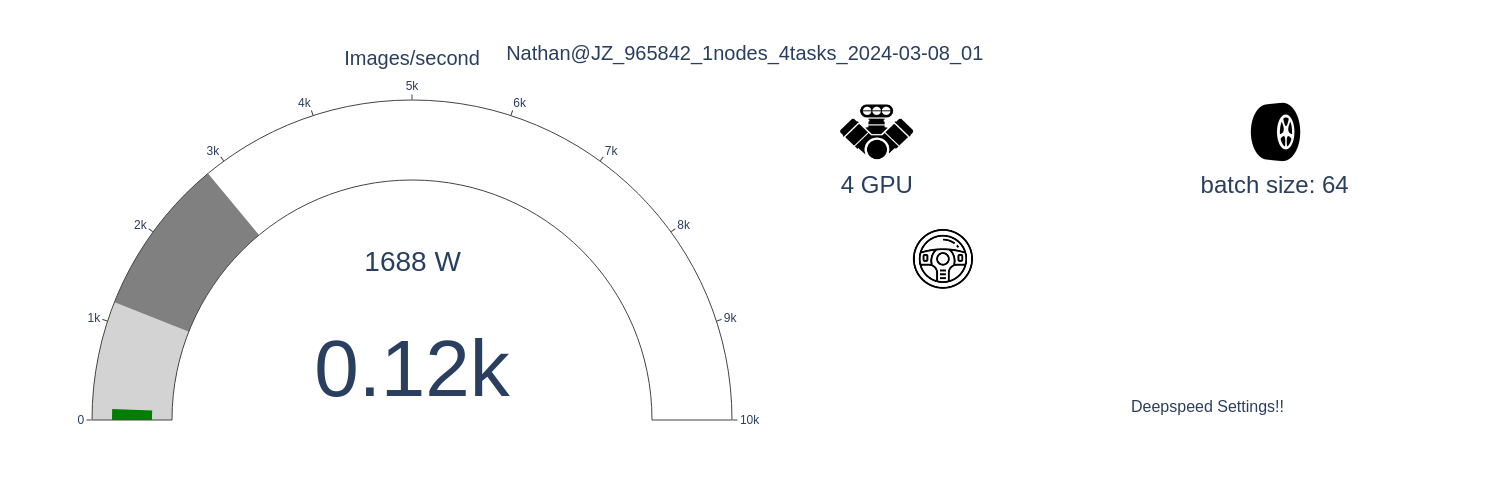

Train throughput: 115.86 images/second
GPU throughput: 116.64 images/second
epoch time: 11058.64 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.548711 sec (23.6%/65.7%) +/- 0.064109
loading step time average (IO + CPU to GPU transfer): 0.003696 sec +/- 0.003424


In [85]:
controle_technique(jobid, deepspeed=True)

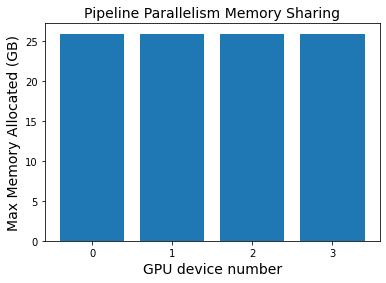

In [86]:
pipe_memory(jobid)

### Test d'occupation mémoire

Afin de mesurer l'impact de la taille de batch sur l'occupation mémoire et sur le *throughput*, la cellule suivante permet de soumettre plusieurs *jobs* avec des tailles de *batch* croissantes. Dans les cas où la mémoire est saturée et dépasse la capacité du GPU, le système renverra une erreur *CUDA Out of Memory*.

In [82]:
import json
batch_size = [8, 16, 32, 64]
for b in batch_size:
    with open("ds_config.json", "r") as jsonFile:
        data = json.load(jsonFile)

    data["train_micro_batch_size_per_gpu"] = b

    with open(f"ds_config{b}.json", "w") as jsonFile:
        json.dump(data, jsonFile)

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [83]:
n_gpu = 4
command = [f'dlojz.py -b {b} --test --deepspeed --deepspeed_config ds_config{b}.json'
          for b in batch_size]
jobids = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobids = {jobids}')

batch job 0: 4 GPUs distributed on 1 nodes with 4 tasks / 4 gpus per node and 8 cpus per task
Submitted batch job 965843
Submitted batch job 965844
Submitted batch job 965846
Submitted batch job 965847
jobids = ['965843', '965844', '965846', '965847']


Copier-coller la sortie `jobids = ['xxxxx', ...]` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [42]:
#jobids = ['169112', '169113', '169114', '169115', '169116', '169117']

In [43]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            958839    gpu_p5   Nathan  ssos025  R       3:42      1 jean-zay-iam19

 Done!


/gpfsdswork/projects/idris/sos/ssos025/formations/dlo-jz/Jour4/tp_gros_models/dlojz_tools.py:275: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



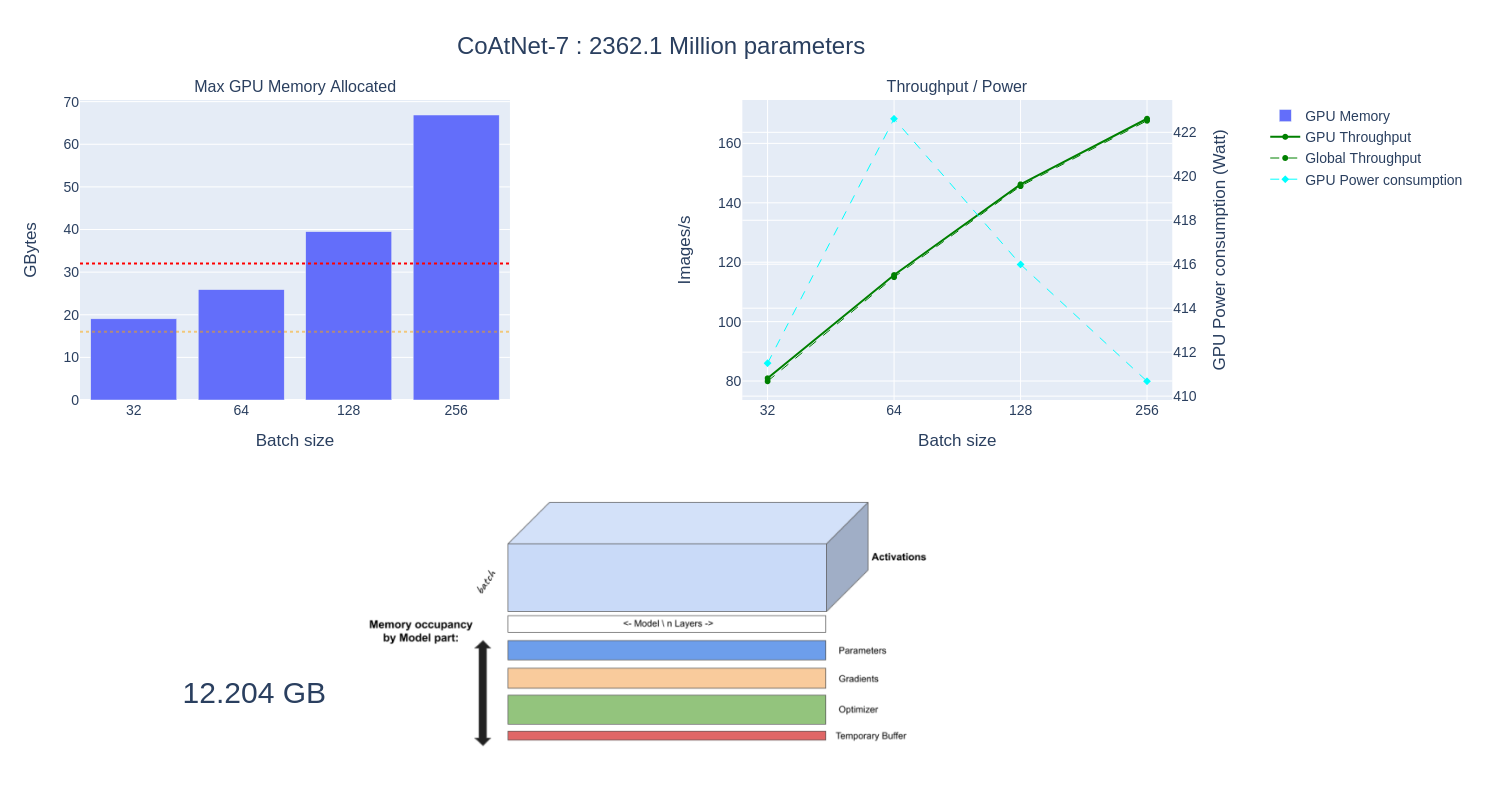

Batch size per GPU: 32 Max GPU Memory Allocated: 19.05 GB, Troughput: 80.916 images/second
Batch size per GPU: 64 Max GPU Memory Allocated: 25.89 GB, Troughput: 115.683 images/second
Batch size per GPU: 128 Max GPU Memory Allocated: 39.49 GB, Troughput: 146.203 images/second
Batch size per GPU: 256 Max GPU Memory Allocated: 66.87 GB, Troughput: 168.295 images/second
Memory occupancy by Model part : 12.204 +/- 0.071 GB


In [88]:
GPU_underthehood(jobids)

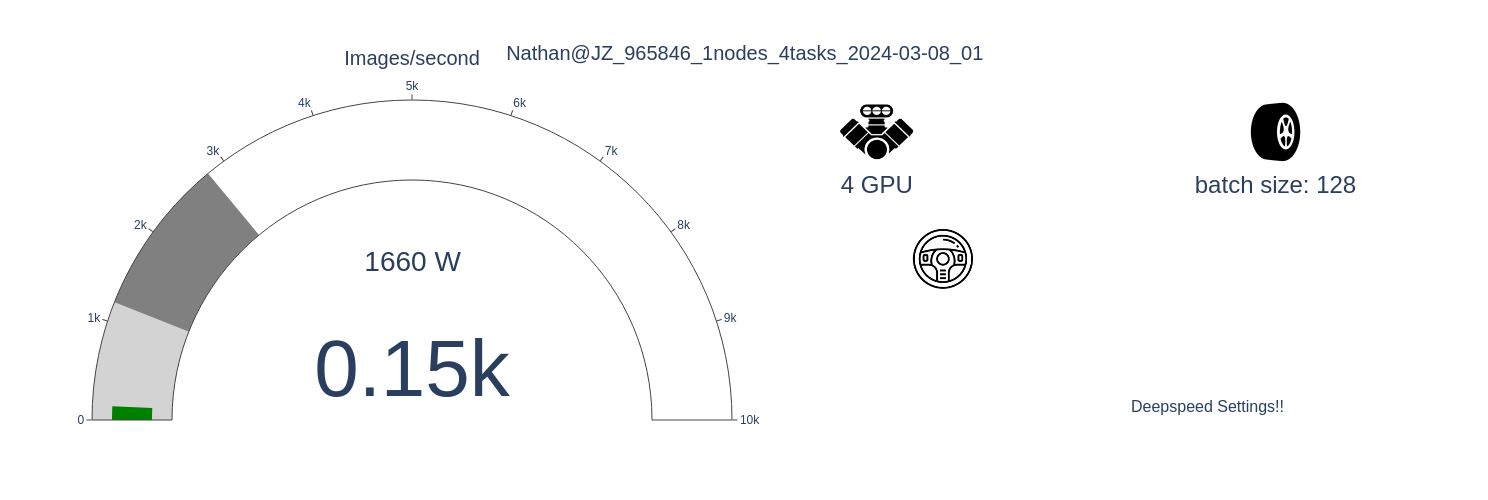

Train throughput: 145.62 images/second
GPU throughput: 146.20 images/second
epoch time: 8798.93 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.875496 sec (28.5%/64.3%) +/- 0.069135
loading step time average (IO + CPU to GPU transfer): 0.003518 sec +/- 0.002785


In [89]:
controle_technique([jobids[-2]], deepspeed=True)

![Commentaires](images/cedez.png "Assurez-vous que tout se passe bien avant de continuer!")

---------------------------------
# TP3_4 : Pipeline Parallelism avec Deepspeed

Ce TP consite à implémenter le *Pipeline Parallelism* de *Deepspeed* que l'on pourra ensuite utiliser en mode hybride avec le *Data Parallelism* + *ZeRO*.

La version du *Pipelined Parallelism* de *Deepspeed* est optimisé pour économiser l'empreinte mémoire.

![pipeline deepspeed](images/pipe-schedule.png)

**À noter** : Avec *Deepspeed*, le *Pipelined Parallelism* comme le *Data Parallism* fonctionne toujours en *multi-task*, ainsi une *task* est associée à chaque *device*.

L'implémentation du *Pipeline Parallelism* amenant trop de changements par rapport au code manipulé durant le TP, nous vous suggérons de copier-coller la solution `solutions/dlojz4_4.py` sur `dlojz.py`.

**TODO** :
* Copier-coller `solutions/dlojz4_4.py` sur `dlojz.py`.
* Regarder le code. Notamment :

```python
# Define Pipeline Module
deepspeed.init_distributed(distributed_port=os.environ['MASTER_PORT'])
model = PipelineModule(layers = [
                    *model.s0, *model.s1, *model.s2, *model.pres3, *model.s3, *model.s4,
                     model.pool, lambda x: x.view(-1, 3072), model.fc],
                     num_stages = args.nb_pipeline_stages,
                     loss_fn=criterion,
                     partition_method = 'parameters' if args.partition_param else 'uniform')

# Deepspeed initialization - force port number if several job run on the same node 
model_engine, optimizer, _, scheduler = deepspeed.initialize(args=args,
                                                     model=model, 
                                                     model_parameters=model.parameters(),
                                                     training_data=train_dataset)
...

    loss = model_engine.train_batch()
....    
    
    val_loss = model_engine.eval_batch(val_iter)

```

#### Configuration *JSON* :

**À noter** : la configuration du *Pipeline Parallelism* se fait avec :
* `train_micro_batch_size_per_gpu` correspondant à la taille du **micro batch**,
* `gradient_accumulation_steps` correspondant au nombre de *tronçons* du *pipeline*.

La taille du *mini batch* pour chaque itération d'apprentissage correspond donc à `train_micro_batch_size_per_gpu` x `gradient_accumulation_steps`.

In [90]:
%%writefile ds_config.json
{ "train_micro_batch_size_per_gpu": 64,
  "gradient_accumulation_steps": 8,
  
  "fp16": {
    "enabled": true
 },
  "optimizer": {
    "type": "AdamW",
    "params": {
      "lr": 0.001,
      "weight_decay": 5e-4
    }
  },
 "scheduler": {
      "type": "OneCycle",
      "params": {
          "cycle_min_lr": 1e-6,
          "cycle_max_lr": 1e-3,
          "decay_lr_rate": 1e-6
      }
  },

 "zero_allow_untested_optimizer": true
}

Overwriting ds_config.json


Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [98]:
n_gpu = 4
command = f'dlojz.py -p 4 --test --deepspeed --deepspeed_config ds_config.json'
jobid = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 4 GPUs distributed on 1 nodes with 4 tasks / 4 gpus per node and 8 cpus per task
Submitted batch job 965879
jobid = ['965879']


Copier-coller la sortie `jobid = ['xxxxx']` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [54]:
#jobid = ['230538']

In [101]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            965884    gpu_p5   Nathan  ssos025  R      14:41      1 jean-zay-iam29
            965885    gpu_p5   Nathan  ssos025  R      14:41      1 jean-zay-iam29
Key interrupt


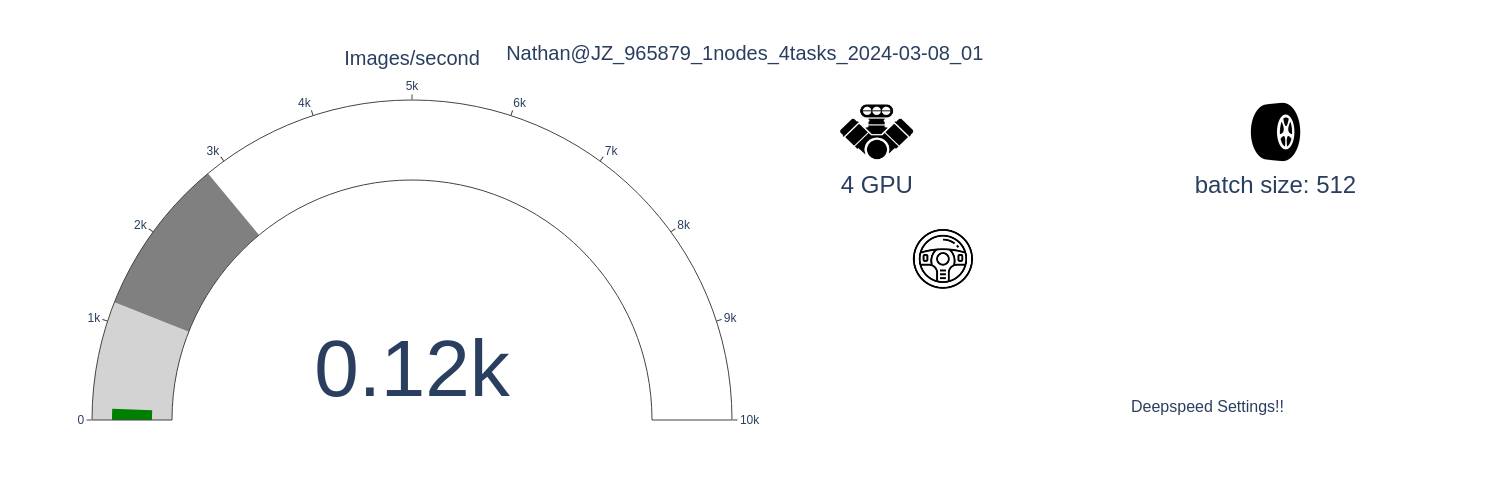

Train throughput: 120.52 images/second
GPU throughput: 120.52 images/second
epoch time: 10633.63 seconds
-----------
training step time average (fwd/bkwd on GPU): 4.248351 sec (nan%/nan%) +/- 1.651583
loading step time average (IO + CPU to GPU transfer): 0.000001 sec +/- 0.000000


In [102]:
controle_technique(jobid, deepspeed=True)

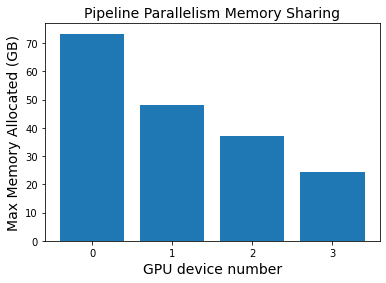

In [105]:
pipe_memory(jobid)

### Optimisation du *chunk number*

### Test d'occupation mémoire

Afin de mesurer l'impact de la taille de batch sur l'occupation mémoire et sur le *throughput*, la cellule suivante permet de soumettre plusieurs *jobs* avec des tailles de *batch* croissantes. Dans les cas où la mémoire est saturée et dépasse la capacité du GPU, le système renverra une erreur *CUDA Out of Memory*.

In [99]:
import json
chunks_numbers = [1, 2, 4, 8, 16]
for c in chunks_numbers:
    with open("ds_config.json", "r") as jsonFile:
        data = json.load(jsonFile)

    data["gradient_accumulation_steps"] = c

    with open(f"ds_config{c}.json", "w") as jsonFile:
        json.dump(data, jsonFile)

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [100]:
n_gpu = 4
command = [f'dlojz.py --image-size {image_size} -p 4 --test --deepspeed --deepspeed_config ds_config{c}.json'
           for c in chunks_numbers]
jobids = gpu_jobs_submitter(command, n_gpu, MODULE, name=name,
                   account=account, time_max='00:20:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobids = {jobids}')

batch job 0: 4 GPUs distributed on 1 nodes with 4 tasks / 4 gpus per node and 8 cpus per task
Submitted batch job 965880
Submitted batch job 965881
Submitted batch job 965882
Submitted batch job 965883
Submitted batch job 965884
Submitted batch job 965885
jobids = ['965880', '965881', '965882', '965883', '965884', '965885']


Copier-coller la sortie `jobids = ['xxxxx', ...]` dans la cellule suivante.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [70]:
#jobids = ['239664', '239666', '239667', '239668', '239674', '239676']

In [ ]:
display_slurm_queue(name)

/gpfsdswork/projects/idris/sos/ssos025/formations/dlo-jz/Jour4/tp_gros_models/dlojz_tools.py:275: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



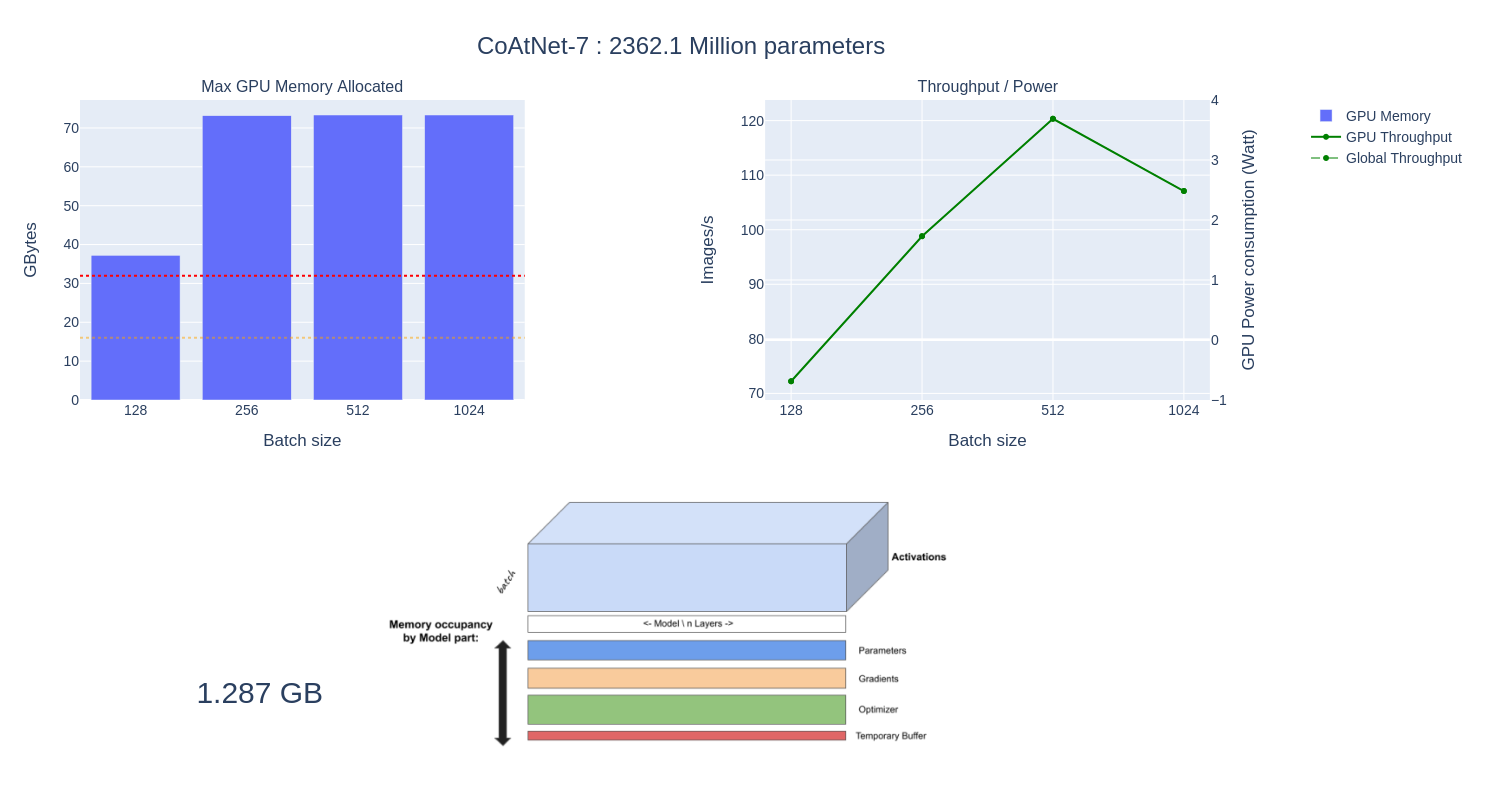

Batch size per GPU: 128 Max GPU Memory Allocated: 37.22 GB, Troughput: 72.228 images/second
Batch size per GPU: 256 Max GPU Memory Allocated: 73.15 GB, Troughput: 98.813 images/second
Batch size per GPU: 512 Max GPU Memory Allocated: 73.34 GB, Troughput: 120.341 images/second
Batch size per GPU: 1024 Max GPU Memory Allocated: 73.34 GB, Troughput: 107.099 images/second
Memory occupancy by Model part : 1.287 +/- 0.000 GB


In [108]:
GPU_underthehood(jobids, calcul_memo=True)

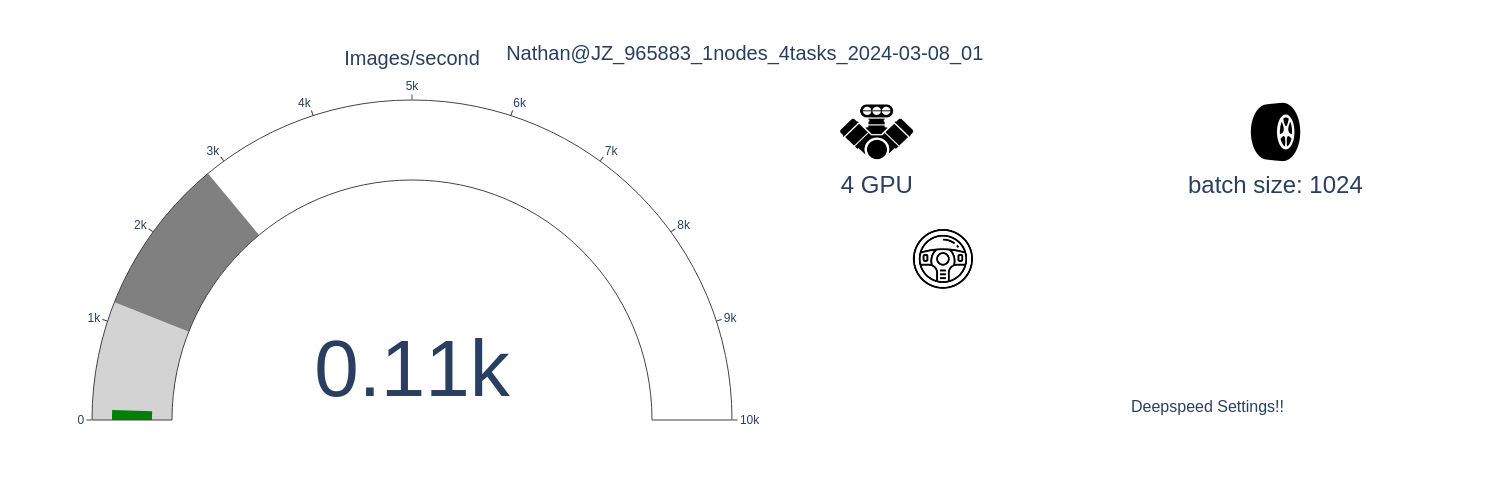

Train throughput: 107.10 images/second
GPU throughput: 107.10 images/second
epoch time: 11970.69 seconds
-----------
training step time average (fwd/bkwd on GPU): 9.561252 sec (nan%/nan%) +/- 3.140544
loading step time average (IO + CPU to GPU transfer): 0.000001 sec +/- 0.000000


In [109]:
controle_technique([jobids[-1]], deepspeed=True)

---------------------------------
# TP3_5 : Fully Sharded Data Parallelism

Enfin, on va essayer d'implémenter la FSDP. Il se trouve que l'implémentation de la FSDP est très semblable à la DDP standard. On vous conseille donc de repartir de la solution `solutions/dlojz4_1.py` qui utilise la DDP standard sur CoAtNet-7.

![fsdp](images/fsdp.png)

**TODO** :
* Copier-coller `solutions/dlojz4_1.py` sur `dlojz.py`.

* Importer les modules que nous allons utiliser pour implémenter FSDP

```python
from CoAtNet.coatnet import coatnet_7, Transformer, MBConv
from torch.distributed.fsdp import FullyShardedDataParallel
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
```

* Implémenter FSDP.

<details><summary>Solution</summary>

```python
model = FullyShardedDataParallel(
    model,
    auto_wrap_policy=functools.partial(
        transformer_auto_wrap_policy, transformer_layer_cls={ Transformer, MBConv }
    ),
)
```
    
_Note: FSDP remplace la classe DistributedDataParallel._
</details>

In [115]:
n_gpu = 4
command = f'dlojz.py --test --batch-size 32'
jobid = gpu_jobs_submitter(command, n_gpu, "pytorch-gpu/py3/2.1.1", name=name,
                   account=account, time_max='00:10:00', constraint='a100', qos="qos_gpu-dev")
print(f'jobid = {jobid}')

batch job 0: 4 GPUs distributed on 1 nodes with 4 tasks / 4 gpus per node and 8 cpus per task
Submitted batch job 965908
jobid = ['965908']


In [116]:
display_slurm_queue(name)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            965908    gpu_p5   Nathan  ssos025  R       4:22      1 jean-zay-iam27

 Done!


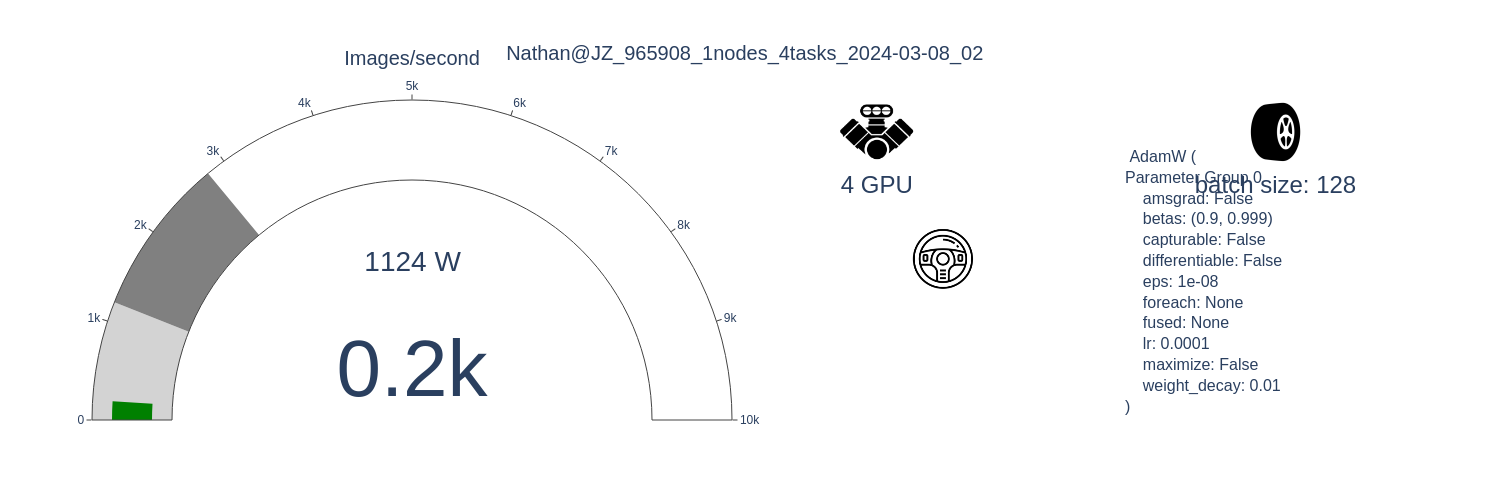

Train throughput: 199.73 images/second
GPU throughput: 199.80 images/second
epoch time: 6414.95 seconds
-----------
training step time average (fwd/bkwd on GPU): 0.640645 sec (98.6%/0.1%) +/- 0.039438
loading step time average (IO + CPU to GPU transfer): 0.000209 sec +/- 0.000049


In [117]:
controle_technique(jobid)

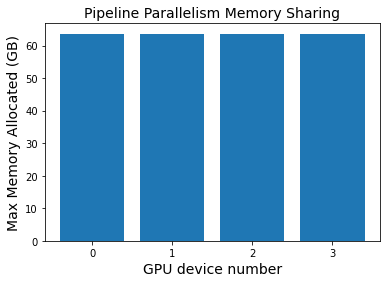

In [118]:
pipe_memory(jobid)

![Commentaires](images/cedez.png "La suite correspond aux annexes, vous etes arrivé à bout du TP, BRAVO")


--------------